In [2]:
import torch
import gc
import pickle
import random
from torch.utils.data import DataLoader
import sys
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

ROOT_DIR = Path.cwd().parent
sys.path.append(str(ROOT_DIR))

from src.data import LOCCADataset  # noqa: E402, F401
from src.constants import BATCH_SIZE  # noqa: E402, F401
from src.module import LOCCAModel

LOCCA_DIR = ROOT_DIR / 'datasets/locca'
RESULTS_DIR = ROOT_DIR / 'results'

volumes_paths = np.array(sorted(LOCCA_DIR.glob('images*/*/*.nii.gz'), key=lambda p:p.name))

### Carregar dados de teste

In [ ]:
# Verificão
# pkls = {
#     1: [], # repet1
#     2: [], # repet2
#     3: [], # repet3
# }

# for pkl_path in sorted(RESULTS_DIR.glob('phase_1/pngs_paths/*/repet*/*.pkl')):
#     repet = int(pkl_path.parent.name[-1])

#     with open(pkl_path, 'rb') as f:
#         pkls[repet].append(pickle.load(f))


# for kfolditer in range(10):
#     assert pkls[1][kfolditer] == pkls[2][kfolditer] and pkls[2][kfolditer] == pkls[3][kfolditer]

#Ok. A divisão de dados de uma iteração do kfold é a mesma, para cada repetição.

In [ ]:
#TODO: dado um .ckpt, verificar repetição e iteração do kfold para obter os paths de teste

In [2]:
ckpt_path = RESULTS_DIR/'phase_1/DeepLabV3Plus_phase1_repet1_kfolditer0_epoch005_step10770_last_20260113-031046.ckpt'

In [3]:
import albumentations as A

test_transform = A.Compose([
    A.Resize(width=256, height=256),
    A.ToTensorV2(),
])

test_paths = []
with open(RESULTS_DIR/f'phase_1/pngs_paths/{ckpt_path.stem.split('_')[3]}_test.pkl', 'rb') as f:
    test_paths = pickle.load(f)

test_dataset = LOCCADataset(
    test_paths,
    test_transform
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4
)

In [4]:
def visualize_batch_overlay(batch, n_samples=4, alpha=0.5):
    volume = batch["volume"].squeeze(1)
    mask = batch["mask"]

    B = volume.shape[0]
    idxs = random.sample(range(B), min(n_samples, B))

    fig, axs = plt.subplots(len(idxs), 3, figsize=(6, 3 * len(idxs)))

    if len(idxs) == 1:
        axs = [axs]

    for lin, i in zip(axs, idxs):
        ct = volume[i].cpu().numpy()
        m = mask[i].cpu().numpy()

        lin[0].imshow(ct, cmap="gray")
        lin[0].set_title(f"slice [{i}]\nftype: {volume[i].cpu().dtype}")
        lin[0].axis("off")

        lin[1].imshow(m, cmap="Reds")
        lin[1].set_title(f"mask [{i}]\nvalues: {np.unique(m)}\ndtype: {mask[i].cpu().dtype}")
        lin[1].axis("off")

        lin[2].imshow(ct, cmap="gray")
        lin[2].imshow(m > 0, cmap="Reds", alpha=alpha)
        lin[2].set_title(f"Overlay slice [{i}]")
        lin[2].axis("off")

    plt.tight_layout()
    plt.show()




In [5]:
loader = iter(test_loader)

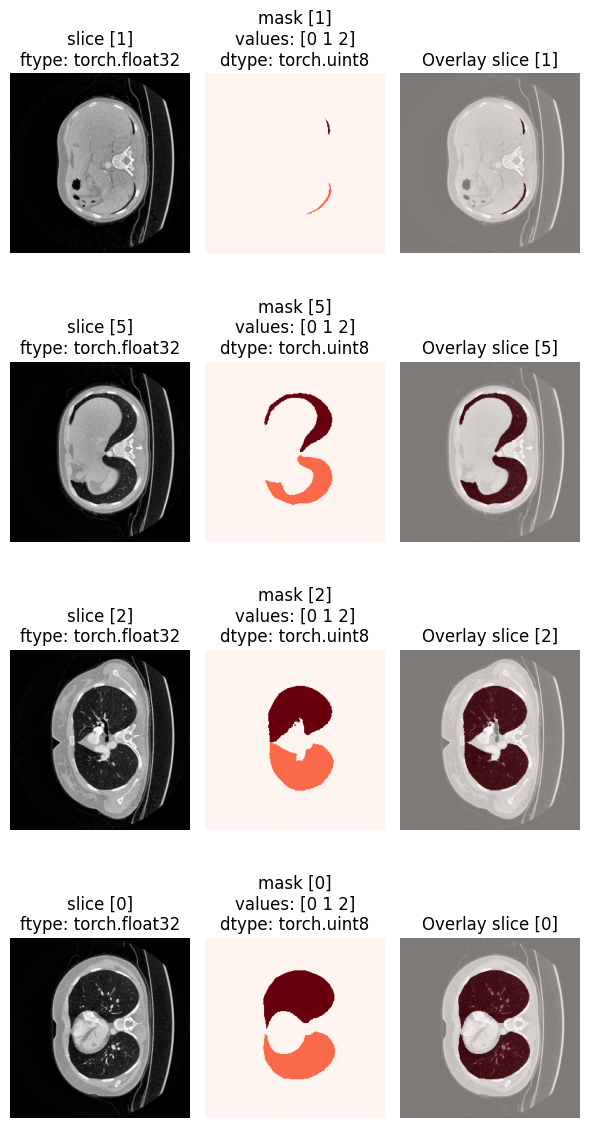

In [6]:
batch = next(loader)
visualize_batch_overlay(next(loader))

In [8]:
# Com base na docs do pytorch lightning:
model = LOCCAModel.load_from_checkpoint(
    ckpt_path,
    arch=ckpt_path.stem.split('_')[0],
    encoder_name='mobilenet_v2',
    in_channels=1,
    out_classes=3,
    phase=ckpt_path.parent.name,
    repetition=int(ckpt_path.stem.split('_')[2][-1]),
    kfolditer=int(ckpt_path.stem.split('_')[3][-1])
)

model.eval()

y_hat = model(batch['volume'])

In [9]:
y_hat.shape

torch.Size([8, 3, 256, 256])

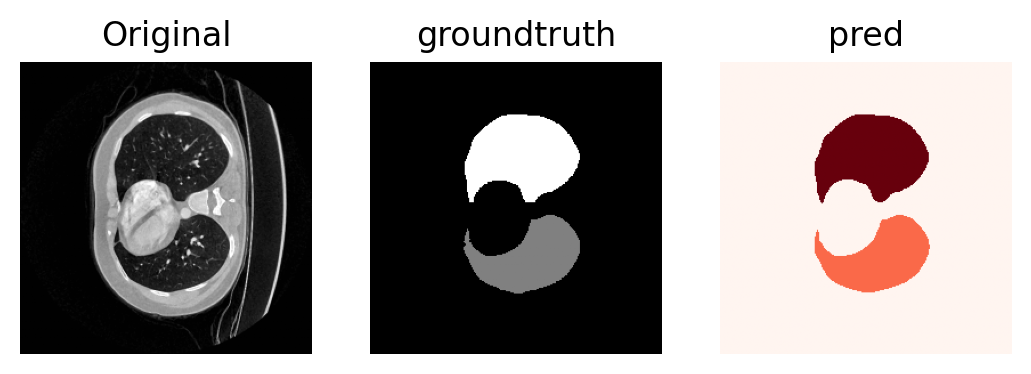

In [16]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, dpi=200)
slice = 4

axs[0].imshow(batch['volume'][slice].permute(1, 2, 0).detach().numpy(), cmap='gray')
axs[0].axis('off')
axs[0].set_title('Original')

axs[1].imshow(batch['mask'][slice].detach().numpy(), cmap='gray')
axs[1].axis('off')
axs[1].set_title('groundtruth')


pred = y_hat[slice].argmax(dim=0)

axs[2].imshow(pred, cmap='Reds')
axs[2].axis('off')
axs[2].set_title('pred')



plt.show()

fig.savefig(RESULTS_DIR/'phase_1/preds_vis/a_pred.png')
# plt.imshow(y_hat[0].permute(1, 2, 0).detach().numpy())
#TODO: fazer um código de visualização bonito

### Plots em cascata
Utilizando as células acima e o notebook nº3 como contexto para um LLM

In [12]:
import re
import gc
import torch
import numpy as np
import pickle
import random
import matplotlib.pyplot as plt
from pathlib import Path
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

# ----------------------------------------
# Config
# ----------------------------------------
PHASE = "phase_1"
REPETITION = 1
KFOLDITER = 0  # primeira iteração do kfold
SEED = 42

OUT_DIR = RESULTS_DIR / PHASE / "preds_vis" / f"repet{REPETITION}_kfolditer{KFOLDITER}"
OUT_DIR.mkdir(parents=True, exist_ok=True)

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# ----------------------------------------
# Helpers
# ----------------------------------------
def parse_ckpt_stem(stem: str) -> dict:
    """
    Exemplo stem:
    DeepLabV3Plus_phase1_repet1_kfolditer0_epoch005_step10770_last_20260113-031046
    """
    parts = stem.split("_")
    arch = parts[0]
    phase = parts[1]
    repet = int(parts[2].replace("repet", ""))
    kfolditer = int(parts[3].replace("kfolditer", ""))
    return {"arch": arch, "phase": phase, "repetition": repet, "kfolditer": kfolditer}

def get_test_loader(phase: str, kfolditer: int):
    test_transform = A.Compose([
        A.Resize(width=256, height=256),
        ToTensorV2(),
    ])

    pkl_name = f"kfolditer{kfolditer}_test.pkl"
    pkl_path = RESULTS_DIR / phase / "pngs_paths" / pkl_name

    with open(pkl_path, "rb") as f:
        test_paths = pickle.load(f)

    test_dataset = LOCCADataset(test_paths, test_transform)

    return DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=4
    )

def load_model_from_ckpt(ckpt_path: Path):
    meta = parse_ckpt_stem(ckpt_path.stem)
    encoder = "tu-mobilenetv2_100" if meta["arch"]=="DPT" else "mobilenet_v2"

    model = LOCCAModel.load_from_checkpoint(
        ckpt_path,
        arch=meta["arch"],
        encoder_name=encoder,
        in_channels=1,
        out_classes=3,
        phase=ckpt_path.parent.name,
        repetition=int(meta["repetition"]),
        kfolditer=meta["kfolditer"],
    )
    model.eval()
    model.to(device)
    return model, meta

def find_ckpts_for(repetition: int, kfolditer: int, phase: str):
    base = RESULTS_DIR / phase
    # pega todos e filtra por repet/kfold no stem
    ckpts = sorted(base.glob("*.ckpt"))
    out = []
    for p in ckpts:
        if f"repet{repetition}_" in p.stem and f"kfolditer{kfolditer}_" in p.stem:
            out.append(p)
    return out

def predict_batch(model, volume):
    with torch.no_grad():
        y_hat = model(volume.to(device))
        pred = y_hat.argmax(dim=1)  # (B, H, W)
    return pred.detach().cpu()

from matplotlib.colors import ListedColormap

# 0: fundo | 1: pulmão direito | 2: pulmão esquerdo
SEG_CMAP = ListedColormap([
    "#000000",  # fundo - preto
    "#4DA3FF",  # pulmão direito - azul
    "#4DFF88",  # pulmão esquerdo - verde
])


def plot_row(axs_row, ct, gt, preds_by_name, titles):
    axs_row[0].imshow(ct, cmap="gray")
    axs_row[0].set_title("TC", fontsize=10)
    axs_row[0].axis("off")

    axs_row[1].imshow(gt, cmap='gray', vmin=0, vmax=2)
    axs_row[1].set_title("Anotação", fontsize=10)
    axs_row[1].axis("off")

    for j, name in enumerate(titles, start=2):
        axs_row[j].imshow(
            preds_by_name[name],
            cmap=SEG_CMAP,
            vmin=0,
            vmax=2
        )
        axs_row[j].set_title(name, fontsize=10)
        axs_row[j].axis("off")

def make_comparison_figure(batch, preds_dict, out_path: Path, n_samples=6):
    """
    preds_dict: {model_name: pred_tensor(B,H,W)}
    """
    volume = batch["volume"].squeeze(1).cpu().numpy()  # (B,H,W)
    gt = batch["mask"].cpu().numpy()                   # (B,H,W)

    B = volume.shape[0]
    idxs = list(range(min(n_samples, B)))

    model_names = list(preds_dict.keys())
    ncols = 2 + len(model_names)  # CT + GT + cada modelo

    fig, axs = plt.subplots(len(idxs), ncols, figsize=(3.2*ncols, 3.2*len(idxs)), dpi=250)
    if len(idxs) == 1:
        axs = np.expand_dims(axs, axis=0)

    for r, i in enumerate(idxs):
        ct_i = volume[i]
        gt_i = gt[i]

        preds_by_name = {mn: preds_dict[mn][i].numpy() for mn in model_names}
        plot_row(axs[r], ct_i, gt_i, preds_by_name, model_names)

    plt.tight_layout()
    fig.savefig(out_path, bbox_inches="tight")
    plt.close(fig)

# ----------------------------------------
# Pipeline
# ----------------------------------------
test_loader = get_test_loader(PHASE, KFOLDITER)
def get_random_batch(dataset, batch_size, seed=42):
    rng = np.random.default_rng(seed)
    idxs = rng.choice(len(dataset), size=batch_size, replace=False)

    volumes = []
    masks = []

    for i in idxs:
        sample = dataset[i]
        volumes.append(sample["volume"])
        masks.append(sample["mask"])

    return {
        "volume": torch.stack(volumes),
        "mask": torch.stack(masks)
    }

# ----------------------------------------
# batch aleatório, mas fixo
# ----------------------------------------
test_loader = get_test_loader(PHASE, KFOLDITER)
test_dataset = test_loader.dataset

batch = get_random_batch(
    test_dataset,
    batch_size=6,   # quantidade de slices que você quer mostrar
    seed=75       # muda o seed se quiser outra figura
)

ckpt_paths = find_ckpts_for(REPETITION, KFOLDITER, PHASE)
print("CKPTs encontrados:")
for p in ckpt_paths:
    print("-", p.name)

preds_dict = {}

for ckpt_path in ckpt_paths:
    model, meta = load_model_from_ckpt(ckpt_path)
    model_name = meta["arch"].lower()  # ou meta["arch"] se preferir
    preds = predict_batch(model, batch["volume"])
    preds_dict[model_name] = preds

    # limpeza
    del model
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

out_path = OUT_DIR / f"compare_repet{REPETITION}_kfolditer{KFOLDITER}.png"
make_comparison_figure(batch, preds_dict, out_path, n_samples=6)

print("Salvo em:", out_path)


CKPTs encontrados:
- DPT_phase1_repet1_kfolditer0_epoch005_step10770_last_20260113-154236.ckpt
- DeepLabV3Plus_phase1_repet1_kfolditer0_epoch005_step10770_last_20260113-031046.ckpt
- Segformer_phase1_repet1_kfolditer0_epoch005_step10770_last_20260113-003955.ckpt
- UnetPlusPlus_phase1_repet1_kfolditer0_epoch005_step10770_last_20260112-203151.ckpt
Salvo em: /home/duque/Projects/tcc/meu_tcc/results/phase_1/preds_vis/repet1_kfolditer0/compare_repet1_kfolditer0.png
